Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
📄 First few rows of cleaned data:


,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


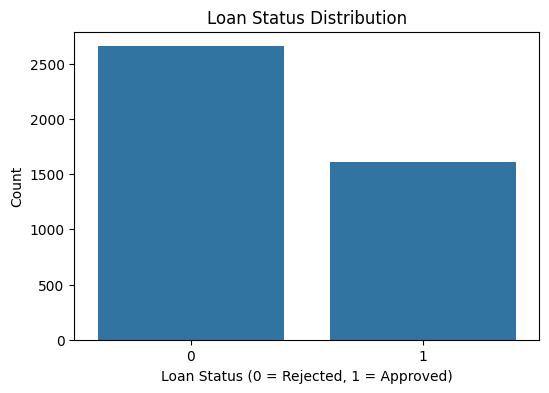


📊 Original Model Accuracy: 0.91
🧮 Confusion Matrix (Before SMOTE):
[[498  38]
 [ 43 275]]

📈 Fairness Metrics (Before SMOTE):
                     accuracy  selection_rate  true_positive_rate
sensitive_feature_0                                              
0                    0.906323        0.358314            0.859873
1                    0.903981        0.374707            0.869565

📊 Re-trained Model Accuracy (After SMOTE): 0.91
🧮 Confusion Matrix (After SMOTE):
[[486  50]
 [ 28 290]]

📈 Fairness Metrics (After SMOTE):
                     accuracy  selection_rate  true_positive_rate
sensitive_feature_0                                              
0                    0.906323        0.400468            0.917197
1                    0.911007        0.395785            0.906832

📌 Feature Importance (Top to Bottom):
income_annum                1.613176
loan_term                   0.862547
no_of_dependents            0.028988
education                   0.022081
residential_asset

<ipython-input-5-afab6ea4903b>:125: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')


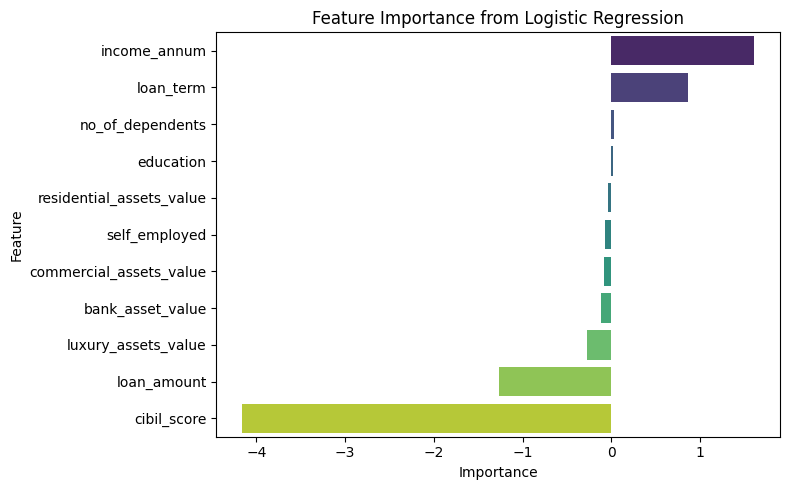

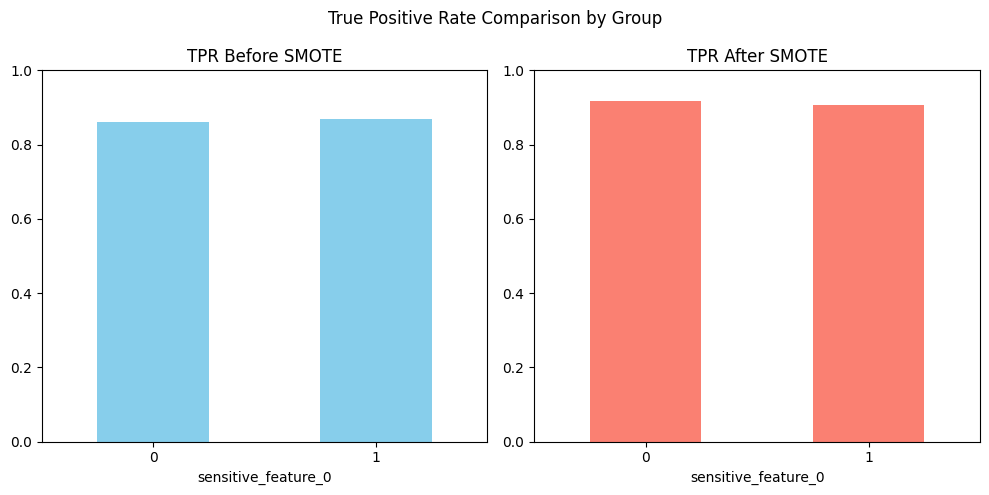


✅ Final Summary:
Original Accuracy: 0.91
SMOTE Accuracy:    0.91

Fairness Before SMOTE:
                      accuracy  selection_rate  true_positive_rate
sensitive_feature_0                                              
0                    0.906323        0.358314            0.859873
1                    0.903981        0.374707            0.869565

Fairness After SMOTE:
                      accuracy  selection_rate  true_positive_rate
sensitive_feature_0                                              
0                    0.906323        0.400468            0.917197
1                    0.911007        0.395785            0.906832


In [5]:
# STEP 1: Install Required Libraries
!pip install imbalanced-learn fairlearn matplotlib seaborn --quiet

# STEP 2: Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix
from imblearn.over_sampling import SMOTE
from fairlearn.metrics import MetricFrame, selection_rate, true_positive_rate

# STEP 3: Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# STEP 4: Load Dataset
file_path = '/content/drive/MyDrive/Colab Notebooks/loan_approval_dataset.csv'
data = pd.read_csv(file_path)

# Fix column names
data.columns = data.columns.str.strip()

# Preview data
print("📄 First few rows of cleaned data:")
display(data.head())

# Drop ID column
if 'loan_id' in data.columns:
    data.drop('loan_id', axis=1, inplace=True)

# Encode categorical columns
label_encoder = LabelEncoder()
for col in ['education', 'self_employed', 'loan_status']:
    if col in data.columns:
        data[col] = label_encoder.fit_transform(data[col])

# Fill missing values
data.fillna(data.mean(numeric_only=True), inplace=True)

# STEP 5: Visualization - Loan Status Distribution
plt.figure(figsize=(6,4))
sns.countplot(x='loan_status', data=data)
plt.title('Loan Status Distribution')
plt.xlabel('Loan Status (0 = Rejected, 1 = Approved)')
plt.ylabel('Count')
plt.show()

# STEP 6: Split Features and Target
X = data.drop('loan_status', axis=1)
y = data['loan_status']

# STEP 7: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# STEP 8: Feature Scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# STEP 9: Train Initial Model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

# Accuracy & Confusion Matrix
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
print(f"\n📊 Original Model Accuracy: {accuracy:.2f}")
print("🧮 Confusion Matrix (Before SMOTE):")
print(conf_matrix)

# STEP 10: Simulated Gender Column (0: Female, 1: Male)
gender = np.array([0 if i % 2 == 0 else 1 for i in range(len(X_test))])

# Fairness Metrics (Before SMOTE)
metric_frame = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'true_positive_rate': true_positive_rate
}, y_true=y_test, y_pred=y_pred, sensitive_features=gender)

print("\n📈 Fairness Metrics (Before SMOTE):")
print(metric_frame.by_group)

# STEP 11: Apply SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

# Retrain Model
model_resampled = LogisticRegression(max_iter=1000)
model_resampled.fit(X_train_resampled, y_train_resampled)
y_pred_resampled = model_resampled.predict(X_test)

# Evaluate Re-trained Model
accuracy_res = accuracy_score(y_test, y_pred_resampled)
conf_matrix_res = confusion_matrix(y_test, y_pred_resampled)

print(f"\n📊 Re-trained Model Accuracy (After SMOTE): {accuracy_res:.2f}")
print("🧮 Confusion Matrix (After SMOTE):")
print(conf_matrix_res)

# Fairness Metrics (After SMOTE)
metric_frame_res = MetricFrame(metrics={
    'accuracy': accuracy_score,
    'selection_rate': selection_rate,
    'true_positive_rate': true_positive_rate
}, y_true=y_test, y_pred=y_pred_resampled, sensitive_features=gender)

print("\n📈 Fairness Metrics (After SMOTE):")
print(metric_frame_res.by_group)

# STEP 12: Feature Importance
feature_names = X.columns
importance = model.coef_[0]
feature_importance = pd.Series(importance, index=feature_names).sort_values(ascending=False)

print("\n📌 Feature Importance (Top to Bottom):")
print(feature_importance)

plt.figure(figsize=(8,5))
sns.barplot(x=feature_importance.values, y=feature_importance.index, palette='viridis')
plt.title("Feature Importance from Logistic Regression")
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

# STEP 13: Visualize Fairness Comparison
metrics_before = metric_frame.by_group
metrics_after = metric_frame_res.by_group

plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
metrics_before['true_positive_rate'].plot(kind='bar', color='skyblue')
plt.title("TPR Before SMOTE")
plt.ylim(0, 1)
plt.xticks(rotation=0)

plt.subplot(1,2,2)
metrics_after['true_positive_rate'].plot(kind='bar', color='salmon')
plt.title("TPR After SMOTE")
plt.ylim(0, 1)
plt.xticks(rotation=0)

plt.suptitle("True Positive Rate Comparison by Group")
plt.tight_layout()
plt.show()

# STEP 14: Final Summary
print("\n✅ Final Summary:")
print(f"Original Accuracy: {accuracy:.2f}")
print(f"SMOTE Accuracy:    {accuracy_res:.2f}")
print("\nFairness Before SMOTE:\n", metrics_before)
print("\nFairness After SMOTE:\n", metrics_after)
